In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as skl
from sklearn import *
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

loc = 'workstation'
if loc == 'workstation':
    wd = 'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    # sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
elif loc == 'laptop':
    wd = '/Users/sammichekroud/Desktop/postdoc/tuningcurves'
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
os.chdir(wd)
from funcs import getSubjectInfo
from TuningCurveFuncs import makeTuningCurve, getTuningCurve_FullSpace, createFeatureBins, visualise_FeatureBins

os.chdir(wd)
subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
#1,2,3,10,19 all have only 1 session. 23 something wrong in the second session, completely unusable eeg data due to serious noise
nsubs = subs.size
#set params for what file to load in per subject
binstep  = 15
binwidth = 22
binstep, binwidth = 4, 11
#binstep, binwidth = 4, 16
binstep, binwidth = 4, 22
binstep, binwidth = 15, 22


times = np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy'))
ntimes = times.size
nitems = 2 #two items are presented in the array, we 'decode' both

nbins, binmids, binstarts, binends = createFeatureBins(binstep = binstep, binwidth = binwidth,
                                                       feature_start = -90+binstep, feature_end = 90)
binmidsrad = np.deg2rad(binmids)

<font color='red'>

the aim of this script is to visualise what the 'typical' method of looking at sensory evidence finds in this data.

In the typical pipeline, mahalanobis distances are used to look at the similarity of a left-out test trial, compared to trials of all other orientations. orientations are grouped into bins of similar orientations to calculate the average pattern associated with this bin, and the distance between a test trial and each of these reference bins is calculated.

This distance is always positive, and smaller distances indicate patterns of activity that are closer to each other. thus larger values actually indicate further distances, or more _dissimilar_ patterns of activity.

Previous studies using this mahalanobis approach have demeaned distances across orientation bins, then inverted (multplied by -1) such that larger numbers indicate larger similarity. In this way, we expect to see something that looks like a cosine function, with more similarity between the test trial and orientation bins that are close in the features, with further distances (smaller or more negative numbers) for orientations that are further away in the circular space.

Typically, this vector of distances across orientation is convolved (multiplied) with the cosine of the bin centre, and the average of this cosine-convolved distance vector is taken as a metric of sensory evidence. Where there is little change in pattern similarity as a function of orientation (i.e. closer orientations are not more similar than further orientations), this average cosine-convolved distance will tend towards zero. when there is a 'peak' in the distance vector such that more similar orientations are closer in distance-space than more different orientations, the average of the cosine-convolved distances will be higher.

However, the caveat is that the natural shape of the cosine in this feature range will suppress the mahalanobis distances of more dissimilar orientations towards zero, while preserving the distances of closer orientations. this effectively inflates the extent to which the vector of distances follows a cosine shape, and will tend towards a more positive average value even where there may be no orientation preference in the tuning curve. For example, below we can see how the convolution of the distance vector with a cosine function brings edges of a simulated tuning curve to zero, which will accentuate any shape around the middle and inflate any orientation tuning.

In [2]:
#for example, let us create a vector of ones with some noise
y = np.ones(nbins) + np.random.rand(nbins)
ydm  = y - y.mean() #demean these distances
ycos = np.cos(binmidsrad) * 0.2 + np.random.rand(nbins) *0.3
ycosdm = ycos - ycos.mean()

average cosine convolved distance = -0.002126518677622729


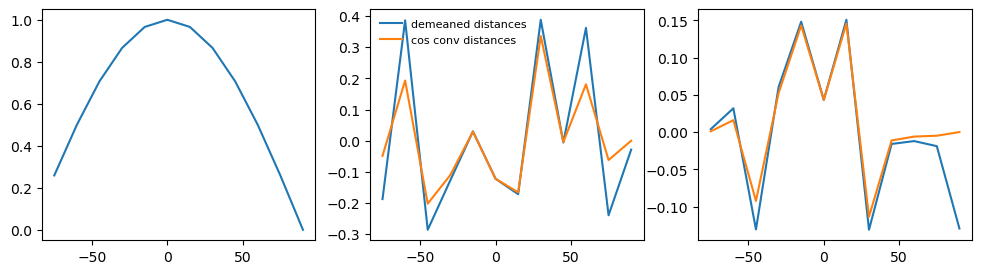

In [3]:
fig = plt.figure(figsize = [12,3])
ax = fig.add_subplot(131)
ax.plot(binmids, np.cos(binmidsrad))
ax = fig.add_subplot(132)
ax.plot(binmids, ydm, label = 'demeaned distances')
ax.plot(binmids, np.multiply(np.cos(binmidsrad), ydm), label = 'cos conv distances')
ax.legend(frameon=False, fontsize = 8)
ax2 = fig.add_subplot(133)
ax2.plot(binmids, ycosdm)
ax2.plot(binmids, np.multiply(np.cos(binmidsrad), ycosdm))
print(f'average cosine convolved distance = {-np.multiply(np.cos(binmidsrad), ydm).mean()}')

<font color='blue'>

now we can see how this pipeline of convolving distances with a cosine and taking the mean of the cosine-convolved distance vector as a metric of sensory evidence looks in our data set, to see what the currently-done process looks like

In [4]:
weightTrials = True
binstep, binwidth = 4, 11
alld = np.zeros(shape = [nsubs, ntimes]) *np.nan
subcount = -1
for i in subs:
    subcount += 1
    data = np.load(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_mahaldists_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
    bdata = pd.read_csv(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_metadata.csv'))
    
    [nitems, ntrials, nbins, ntimes] = data.shape

    data = np.load(op.join(wd, 'data','tuningcurves', f's{i}_CosineConvolvedEvidence_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
    [nitems, ntrials, ntimes] = data.shape
    dnew = data.copy()
    # dnew = sp.ndimage.gaussian_filter1d(data.copy(), sigma=1) #smooth with gaussian smoothing kernal of 1 sample standard deviation (10ms, as 100Hz)

    # dnew = np.zeros(shape = [nitems, ntrials, ntimes]) * np.nan #creating a summary metric across bins
    # #convolving distances with the cosine of their relative orientation, then averaging across orientation bins to get 'cosine amplitude', or 'decoding accuracy'
    # for iitem in range(nitems):
    #     for itrl in range(ntrials):
    #         for it in range(ntimes):
    #             id = data[iitem, itrl, :, it].copy()
    #             idm = id - id.mean()
    #             idcos = np.multiply(np.cos(binmidsrad), idm).mean() *-1
    #             dnew[iitem, itrl, it] = idcos
    # dnew = sp.ndimage.gaussian_filter1d(dnew, sigma = 1) #lightly smooth with a gaussian kernel with sd 2 samples (20ms)

    #average across items then trials
    alld[subcount] = dnew.copy().mean(0).mean(0) #gives a single timecourse of decoding accuracy across time
# alld = alld * 10e2

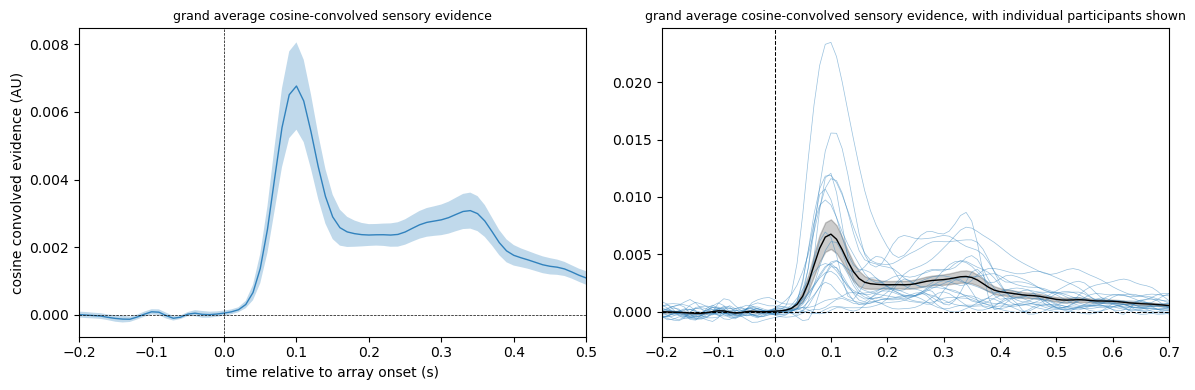

In [5]:
gm = alld.mean(0)
gsem = sp.stats.sem(alld, axis=0, ddof=0, nan_policy='omit')

fig =plt.figure(figsize = [12,4])
ax = fig.add_subplot(121)
ax.plot(times, gm, lw = 1, color = '#3182bd')
ax.fill_between(times, np.add(gm, gsem), np.subtract(gm, gsem), edgecolor=None, alpha=0.3, lw = 0, color='#3182bd')
ax.axvline(0, ls='dashed', color='k', lw=0.5)
ax.axhline(0, ls='dashed', color='k', lw = 0.5)
ax.set_xlim([-0.2, 0.5])
ax.set_xlabel('time relative to array onset (s)')
ax.set_ylabel('cosine convolved evidence (AU)');
ax.set_title('grand average cosine-convolved sensory evidence', fontsize = 9)

# fig = plt.figure()
ax = fig.add_subplot(122)
for isub in range(nsubs):
    ax.plot(times, alld[isub], lw = 0.5, alpha = 0.5, color = '#3182bd')
ax.plot(times, gm, lw = 1, color = 'k')
ax.fill_between(times,
                np.add(gm, gsem), np.subtract(gm, gsem),
                alpha = 0.2, edgecolor = None, color = 'k')
ax.axvline(0, ls = 'dashed', color = 'k', lw = 0.75)
ax.axhline(0, ls = 'dashed', color = 'k', lw = 0.75)
ax.set_xlim([-0.2, 0.7])
ax.set_title('grand average cosine-convolved sensory evidence, with individual participants shown', fontsize = 9)
fig.tight_layout()

<font color='red'>

A key sanity check is whether this metric of sensory evidence is sensitive to the way that orientation bins are constructed when calculating the orientation tuning curve using mahalanobis distances. We can visualise this cosine-convolved evidence over time, separately for each combination of binstep (distance between bins) and binwidth (orientation smoothing) to verify

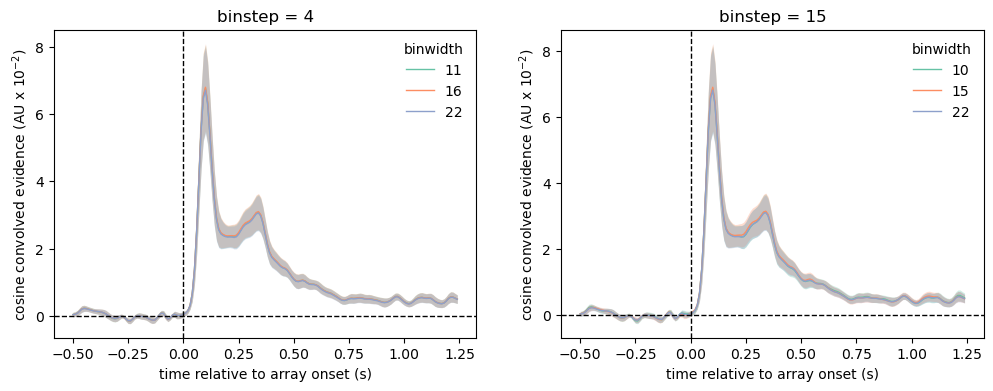

In [6]:
weightTrials = True
cols = ['#66c2a5','#fc8d62','#8da0cb']

fig = plt.figure(figsize = [12,4])
axcount = 0
for binstep in [4, 15]:
    axcount += 1 
    alld = np.zeros(shape = [nsubs, 3, ntimes]) * np.nan
    if binstep == 4:
        widths = [11, 16, 22]
    elif binstep == 15:
        widths = [10, 15, 22]

    ax = fig.add_subplot(1,2,axcount)
    wcount = -1
    for binwidth in widths:
        wcount += 1
        dw = np.zeros(shape = [nsubs, ntimes]) * np.nan
        subcount = -1
        for i in subs:
            subcount += 1
            d = np.load(op.join(wd, 'data', 'tuningcurves', f's{i}_CosineConvolvedEvidence_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
            d = np.multiply(d, 10e2)
            dw[subcount] = d.copy().mean(0).mean(0)

        dm = np.nanmean(dw, axis=0)
        dsem = sp.stats.sem(dw, axis=0, ddof=0, nan_policy='omit')
        ax.plot(times, dm, lw = 1, color = cols[wcount], label = str(binwidth))
        ax.fill_between(times, np.add(dm, dsem), np.subtract(dm, dsem), edgecolor = None, lw = 0, color = cols[wcount], alpha=0.3)
    ax.legend(loc='upper right', frameon=False, title = 'binwidth')
    ax.axvline(0, lw=1, color = 'k', ls = 'dashed')
    ax.axhline(0, lw=1, color = 'k', ls = 'dashed')
    # ax.set_xlim([-0.3, 0.75])
    ax.set_xlabel('time relative to array onset (s)')
    ax.set_ylabel('cosine convolved evidence (AU x $10^{-2}$)')
    ax.set_title(f'binstep = {binstep}')
        

<font color='red'>

it looks like it is largely robust to both changes in binstep and binwidth